In [3]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance


def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

In [4]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)
print(img.min(), img.max())

ct1 = dicom.read_file(in_dir + 'Validation1.dcm')
img1 = ct1.pixel_array

ct2 = dicom.read_file(in_dir + 'Validation2.dcm')
img2 = ct2.pixel_array

ct3 = dicom.read_file(in_dir + 'Validation3.dcm')
img3 = ct3.pixel_array

(512, 512)
int16
-2048 1114


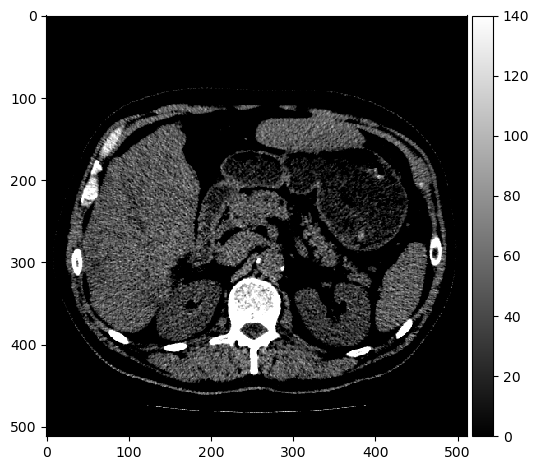

In [5]:
io.imshow(img, vmin=0, vmax=140, cmap='gray')
io.show()

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

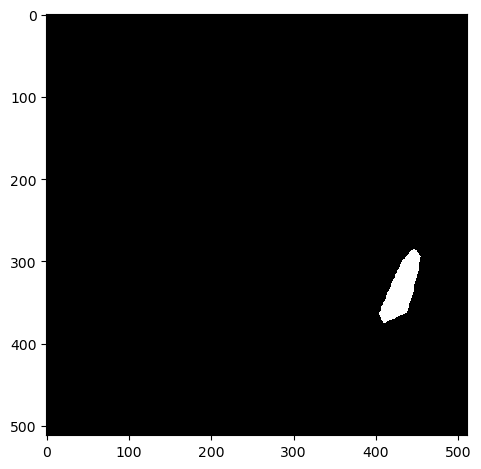

In [33]:
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]
io.imshow(spleen_mask)
spleen_mask

Exercise 2: Compute the average and standard deviation of the Hounsfield units found in the spleen in the training image. Do they correspond to the values found in the above figure?

The mean computed is in the upper part of the spleen HU range shown in the figure above. It lies well within the computed standard deviation.

Exercise 3: Plot a histogram of the pixel values of the spleen. Does it look like they are Gaussian distributed?

The HU value histogram follows a roughly normal distribution.

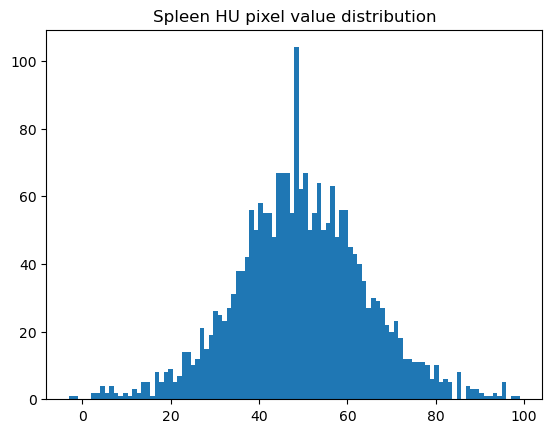

In [7]:
mu_spleen = spleen_values.mean()
std_spleen = np.std(spleen_values)
plt.hist(spleen_values, bins=100)
plt.title('Spleen HU pixel value distribution')
plt.show()

The function norm.pdf from SciPy represents a Gaussian probability density function (PDF). It can for example be used to plot a Gaussian distribution with a given mean and standard deviation.

This can be used to create a fitted Gaussian distribution of the spleen values:

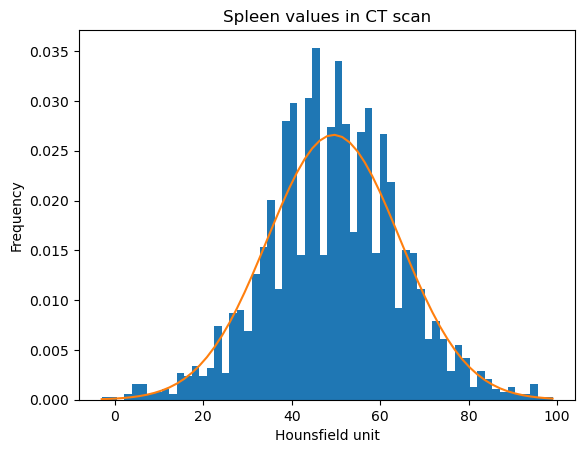

In [8]:
n, bins, patches = plt.hist(spleen_values, 60, density=1)
pdf_spleen = norm.pdf(bins, mu_spleen, std_spleen)
plt.plot(bins, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

Exercise 4: Plot histograms and their fitted Gaussians of several of the tissues types. Do they all look like they are Gaussian distributed?

In [9]:
def get_roi_gaussian(region_name, hu_range):
    roi = io.imread(in_dir + region_name + 'ROI.png')
    # convert to boolean image
    mask = roi > 0
    values = img[mask]

    mu = values.mean()
    std = np.std(values)

    pdf = norm.pdf(hu_range, mu, std)
    return pdf

In [10]:
def get_roi_vals(region_name):
    roi = io.imread(in_dir + region_name + 'ROI.png')
    # convert to boolean image
    mask = roi > 0
    return img[mask]

In [11]:
soft_values = np.append(get_roi_vals('Spleen'), get_roi_vals('Kidney'))
soft_values = np.append(soft_values, get_roi_vals('Liver'))
(mu_soft, std_soft) = norm.fit(soft_values)

bone_values = get_roi_vals('Bone')
(mu_bone, std_bone) = norm.fit(bone_values)

fat_values = get_roi_vals('Fat')
(mu_fat, std_fat) = norm.fit(fat_values)

In [12]:
# Hounsfield unit limits of the plot
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)

pdf_bg = get_roi_gaussian('Background', hu_range) 
pdf_bone = get_roi_gaussian('Bone', hu_range)
pdf_fat = get_roi_gaussian('Fat', hu_range)
pdf_spleen = get_roi_gaussian('Spleen', hu_range)
pdf_kidney = get_roi_gaussian('Kidney', hu_range)
pdf_liver = get_roi_gaussian('Liver', hu_range)
pdf_soft = norm.pdf(hu_range, mu_soft, std_soft)

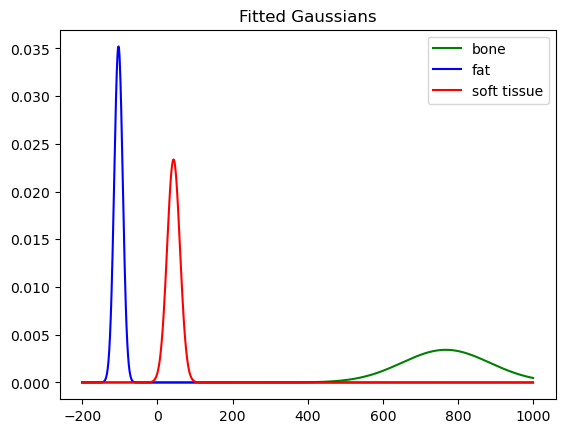

In [13]:
#plt.plot(hu_range, pdf_spleen, 'r-', label="spleen")
plt.plot(hu_range, pdf_bone, 'g', label="bone")
plt.plot(hu_range, pdf_fat, 'b', label="fat")
#plt.plot(hu_range, pdf_kidney, 'm', label="kidney")
#plt.plot(hu_range, pdf_liver, 'orange', label="liver")
plt.plot(hu_range, pdf_soft, 'r', label="soft tissue")
plt.title("Fitted Gaussians")
plt.legend()
plt.show()

Exercise 5: Plot the fitted Gaussians of bone, fat, kidneys, liver and spleen. What classes are easy to seperate and which classes are hard to seperate?

Fat and bone are easy to separate. Kidney and spleen have largely overlapping distributions.

Exercise 6: Define the classes that we aim at classifying. Perhaps some classes should be combined into one class?

We can combine Liver, Kidney and Spleen into one soft tissue class

## Minimum distance pixel classification

In the **minimum distance classifier** the pixel value class ranges are defined using the average values of the training values. If you have two classes, the threshold between them is defined as the mid-point between the two class value averages.

In the following, we will define four classes: **background, fat, soft tissue and bone**, where soft-tissue is a combination of the values of the spleen, liver and kidneys. 
We manually set the threshold for background to -200. So all pixels below -200 are set to background.

**Exercise 7**: *Compute the class ranges defining fat, soft tissue and bone.*

In [14]:
t_background = -200
t_fat_soft = (mu_fat + mu_soft) / 2
t_soft_bone = (mu_soft + mu_bone) / 2

def param_classify(hu_value):
    if hu_value <= t_background:
        return 0
    elif hu_value <= t_fat_soft:
        return 1
    elif hu_value <= t_soft_bone:
        return 2
    else:
        return 3

In [15]:
fat_img = (img > t_background) & (img <= t_fat_soft)
bone_img = (img > t_soft_bone)
soft_img = (img > t_fat_soft) & (img <= t_soft_bone)
bg_img = img <= t_background

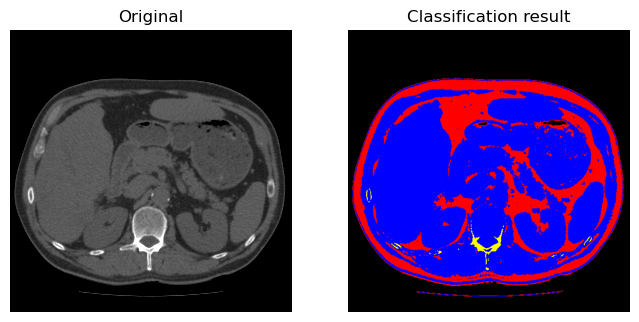

In [16]:
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

**Exercise 9**: *Visualize your classification result and compare it to the anatomical image in the start of the exercise. Does your results look plausible?*

These results look plausible. One clear error is a large part of the vertebra being labelled as soft tissue

## Parametric pixel classification

In the **parametric classifier**, the standard deviation of the training pixel values is also used when determinin the class ranges. In the following, we are also trying to classify **background, fat, soft tissue and bone**.

We start by finding the class ranges by manually inspecting the fitted Gaussians from each class.

As in the last exercise, we can still se the background-fat threshold to be -200.

**Exercise 9**: *Plot the fitted Gaussians of the training values and manually find the intersection between the curves.*

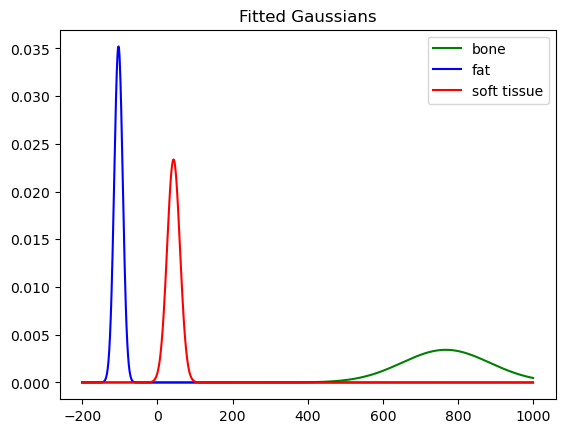

In [17]:
plt.plot(hu_range, pdf_bone, 'g', label="bone")
plt.plot(hu_range, pdf_fat, 'b', label="fat")
plt.plot(hu_range, pdf_soft, 'r', label="soft tissue")
plt.title("Fitted Gaussians")
plt.legend()
plt.show()

In [18]:
idx_fat_soft = np.argwhere(np.diff(np.sign(pdf_soft - pdf_fat)))
idx_soft_bone = np.argwhere(np.diff(np.sign(pdf_bone - pdf_soft)))

param_t_fat_soft = hu_range[idx_fat_soft[0][0]]
param_t_soft_bone = hu_range[idx_soft_bone[1][0]]
print(param_t_fat_soft, param_t_soft_bone)

-45.0 140.0


In [19]:
fat_img_param = (img > t_background) & (img <= param_t_fat_soft)
bone_img_param = (img > param_t_soft_bone)
soft_img_param = (img > param_t_fat_soft) & (img <= param_t_soft_bone)

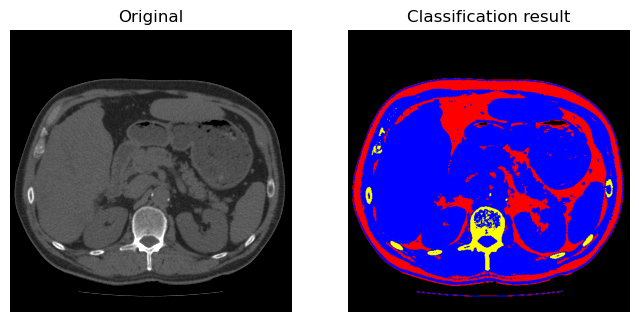

In [20]:
label_img_param = fat_img_param + 2 * soft_img_param + 3 * bone_img_param
param_image_label_overlay = label2rgb(label_img_param)
show_comparison(img, param_image_label_overlay, 'Classification result')

Exercise 10: Use the same technique as in exercise 7, 8 and 9 to visualize your classification results. Did it change compared to the minimum distance classifier?

Using parametric classification improves classification accuracy signficantly. Many bone pixels in the vertebra are now correctly classified. Although their distance to the soft tissue mean was minimized with the previous method, the wide standard deviation of bone pixel values causes it to be classified differently with this method.

Exercise 11: Use norm.pdf to find the optimal class ranges between fat, soft tissue and bone.

In [21]:
hu_lookup = {}

for test_value in range(-2000, 3000):
    if test_value < t_background:
        hu_lookup.update( {test_value : 'Background'} )
    elif norm.pdf(test_value, mu_fat, std_fat) > norm.pdf(test_value, mu_soft, std_soft):
        hu_lookup.update( {test_value : 'Fat'} )
    elif norm.pdf(test_value, mu_soft, std_soft) > norm.pdf(test_value, mu_bone, std_bone):
        hu_lookup.update( {test_value : 'Soft'} )
    else:
        hu_lookup.update( {test_value : 'Bone'} )

## Object segmentation - The spleen finder

The goal of this part of the exercise, is to create a program that can automatically segment the spleen in CT images.

We start by using the **Training.dcm** image and the expert provided annotations.

**Exercise 11**: *Inspect the values of the spleen as in exercise 3 and select a lower and upper threshold to create a spleen class range.*


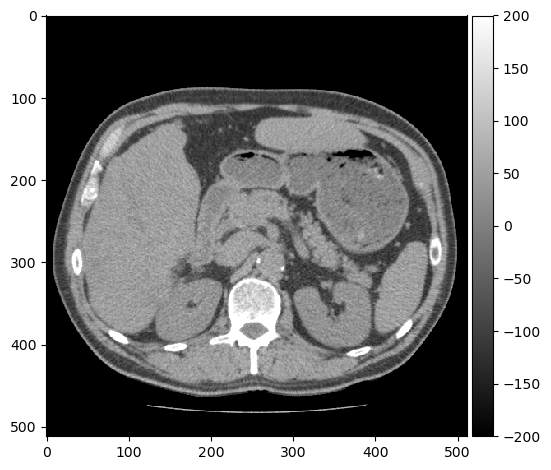

In [22]:
io.imshow(img, vmin=-200, vmax=200, cmap='gray')

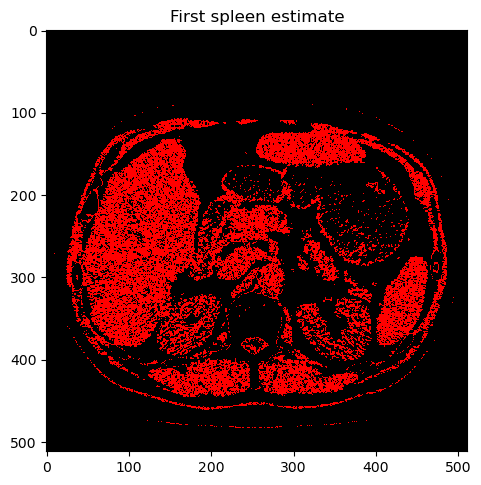

In [23]:
t_1 = 30
t_2 = 70

spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

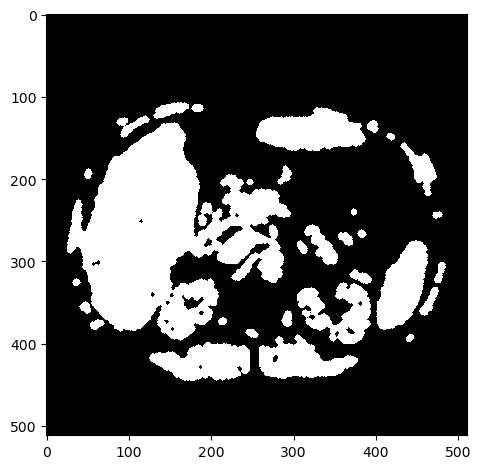

In [24]:
footprint = disk(2)
closed = binary_closing(spleen_estimate, footprint)

footprint = disk(4)
opened = binary_opening(closed, footprint)

io.imshow(opened)

**Exercise 12**: *Use the above morphological operations to seperate the spleen from other organs and close holes. Change the values where there are question marks to change the size of the used structuring elements.*


Now we can use [BLOB](https://github.com/RasmusRPaulsen/DTUImageAnalysis/tree/main/exercises/ex5-BLOBAnalysis) analysis to do a feature based classification of the spleen.

**Exercise 12**: *Use the methods from [BLOB](https://github.com/RasmusRPaulsen/DTUImageAnalysis/tree/main/exercises/ex5-BLOBAnalysis) analysis to compute BLOB features for every seperated BLOB in the image. You can for example start by:*

c:\Users\matth\anaconda3\envs\course02502\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


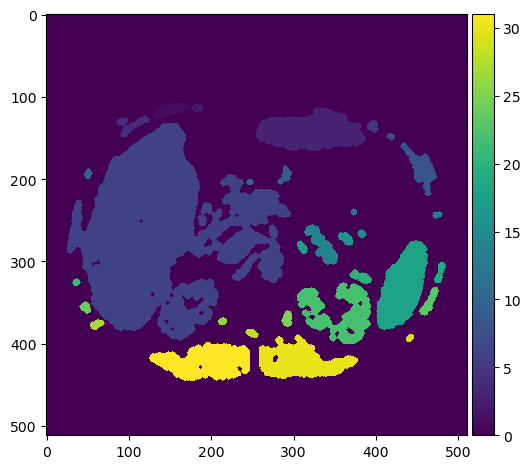

In [25]:
label_img = measure.label(opened)
region_props = measure.regionprops(label_img)
io.imshow(label_img)

4289 304.3330444827409


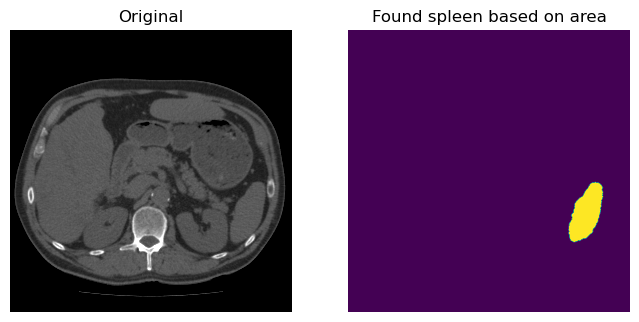

In [26]:
min_area = 2000
max_area = 6000
min_perim = 100
max_perim = 355

# Create a copy of the label_img
label_img_filter = label_img.copy()
for region in region_props:
    # Find the BLOBs that do not fit our criteria
    if  (region.area > max_area or region.area < min_area) or \
        (region.perimeter > max_perim or region.perimeter < min_perim):
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
    else:
        print(region.area, region.perimeter)
# Return binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Found spleen based on area')

**Exercise 15**: *Create a function `spleen_finder(img)` that takes as input a CT image and returns a binary image, where the pixels with value 1 represent the spleen and the pixels with value 0 everything else.*

In [27]:
def spleen_finder(img):
    spleen_estimate = (img > 30) & (img < 70)
    
    footprint = disk(2)
    closed = binary_closing(spleen_estimate, footprint)

    footprint = disk(3)
    opened = binary_opening(closed, footprint)

    label_img = measure.label(opened)
    region_props = measure.regionprops(label_img)

    min_area = 3000
    max_area = 6000
    min_perim = 100
    max_perim = 335

    # Create a copy of the label_img
    label_img_filter = label_img.copy()
    for region in region_props:
        # Find the BLOBs that do not fit our criteria
        if  (region.area > max_area or region.area < min_area) or \
            (region.perimeter > max_perim or region.perimeter < min_perim):
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
        else:
            print(region.area, region.perimeter)
    # Return binary image from the filtered label image
    return label_img_filter > 0

4301 308.0904037956216
3857 285.9482681718907
4610 324.3746750430835
4942 331.3036072312181


Text(0.5, 1.0, 'Image 3')

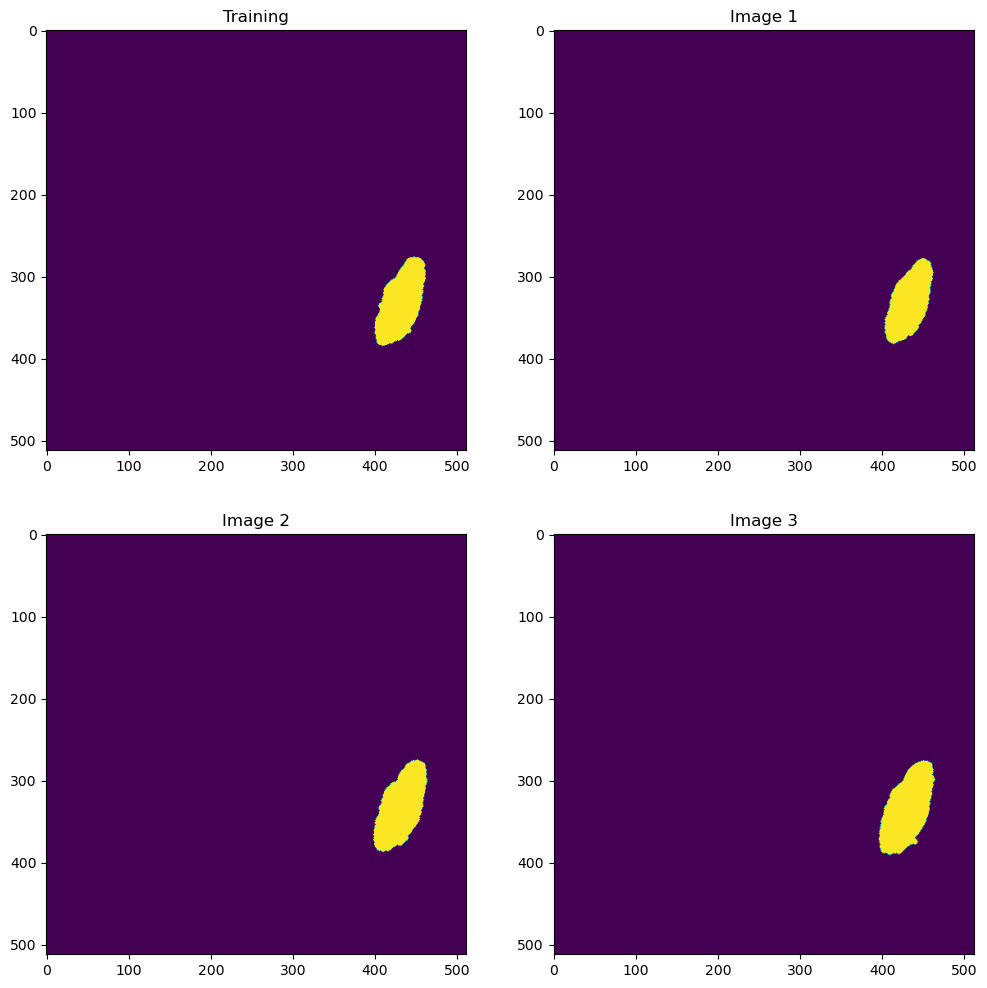

In [28]:
img_spleen  = spleen_finder(img)
img1_spleen = spleen_finder(img1)
img2_spleen = spleen_finder(img2)
img3_spleen = spleen_finder(img3)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
ax1.imshow(img_spleen)
ax1.set_title('Training')

ax2.imshow(img1_spleen)
ax2.set_title('Image 1')

ax3.imshow(img2_spleen)
ax3.set_title('Image 2')

ax4.imshow(img3_spleen)
ax4.set_title('Image 3')

In [29]:
def compute_dice(gt_img, test_bin):
    gt_bin = ground_truth_img > 0
    return 1 - distance.dice(test_bin.ravel(), gt_bin.ravel())

In [30]:
gt_img1 = io.imread(in_dir + 'Validation1_spleen.png')
gt_img2 = io.imread(in_dir + 'Validation2_spleen.png')
gt_img3 = io.imread(in_dir + 'Validation3_spleen.png')

dice1 = compute_dice(gt_img1, img1_spleen)
dice2 = compute_dice(gt_img2, img2_spleen)
dice3 = compute_dice(gt_img3, img3_spleen)

print(dice1, dice2, dice3)

NameError: name 'ground_truth_img' is not defined

In [ ]:
ct = dicom.read_file(in_dir + 'Test1.dcm')
test1 = ct.pixel_array

ct = dicom.read_file(in_dir + 'Test2.dcm')
test2 = ct.pixel_array

ct = dicom.read_file(in_dir + 'Test3.dcm')
test3 = ct.pixel_array

test1_spleen = spleen_finder(test1)
test2_spleen = spleen_finder(test2)
test3_spleen = spleen_finder(test3)

3159 313.11984104714446
3351 265.4629867976521


Text(0.5, 1.0, 'Image 2')

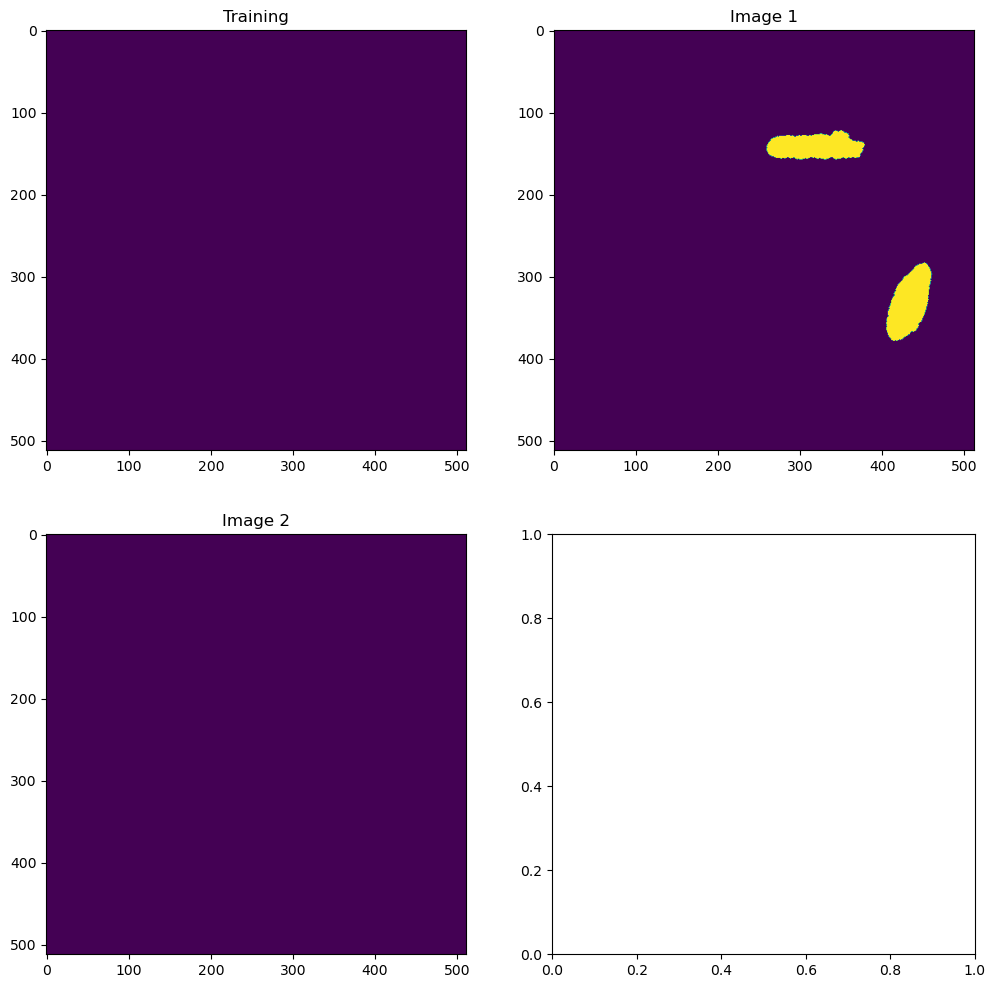

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
ax1.imshow(test1_spleen)
ax1.set_title('Training')

ax2.imshow(test2_spleen)
ax2.set_title('Image 1')

ax3.imshow(test3_spleen)
ax3.set_title('Image 2')